In [6]:
## TP interactomics EBV HUMAN

In [ ]:
# Mise en place des données

In [8]:
import requests
url = "http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270"

try:
    httpReq = requests.get(url, proxies=None)
except NameError:
    httpReq = requests.get(url)
ans = httpReq.text

In [12]:
ans.split('|')

['uniprotkb:P0CW72\tuniprotkb:P0CW72\tintact:EBI-2620133',
 'uniprotkb:Q777A5\tintact:EBI-2620133',
 'uniprotkb:Q777A5\tpsi-mi:barf1_ebvg(display_long)',
 'uniprotkb:BARF1(gene name)',
 'psi-mi:BARF1(display_short)',
 'uniprotkb:33 kDa early protein(gene name synonym)',
 'uniprotkb:p33(gene name synonym)\tpsi-mi:barf1_ebvg(display_long)',
 'uniprotkb:BARF1(gene name)',
 'psi-mi:BARF1(display_short)',
 'uniprotkb:33 kDa early protein(gene name synonym)',
 'uniprotkb:p33(gene name synonym)\tpsi-mi:"MI:0397"(two hybrid array)\tCalderwood et al. (2007)\timex:IM-20435',
 'mint:MINT-6769080',
 'pubmed:17446270\ttaxid:10376(ebvg)',
 'taxid:10376("Epstein-Barr virus (strain B95-8)")\ttaxid:10376(ebvg)',
 'taxid:10376("Epstein-Barr virus (strain B95-8)")\tpsi-mi:"MI:0915"(physical association)\tpsi-mi:"MI:0469"(IntAct)\tintact:EBI-2620961',
 'imex:IM-20435-3\tauthor score:+',
 'intact-miscore:0.51\nuniprotkb:P0C704\tuniprotkb:P14348\tintact:EBI-2620975',
 'uniprotkb:Q3KSQ5\tintact:EBI-2620158',

In [ ]:
# Extraction des deux sous-jeux d'interactions

In [19]:
import re

def mitabReader(httpText):
    for line in ans.split("\n"):
        _ = line.split("\t")
        if len(_) > 1 and _[0].startswith("uniprotkb:")\
                      and _[1].startswith("uniprotkb:"):
            yield [ _[0].replace("uniprotkb:", ""),\
                    _[1].replace("uniprotkb:", "") ]\
                  + _[2:]
                
            
def isMitab_EBV_EBV(mitabArray):
    reEBV = "taxid:(1037[6-7]|82830)"
    if re.search(reEBV, mitabArray[9]) and re.search(reEBV, mitabArray[10]):
        return True
    return False

def isMitab_Human_EBV(mitabLine):
    reHuman = "taxid:9606"
    if re.search(reHuman, mitabArray[9]) or re.search(reHuman, mitabArray[10]):
        return True
    return False

EBV_EBV_mitab   = []
EBV_Human_mitab = []
total = 0
for mitabArray in mitabReader(ans):
    total += 1
    if isMitab_EBV_EBV(mitabArray):
        EBV_EBV_mitab.append(mitabArray)
    elif isMitab_Human_EBV(mitabArray):
        EBV_Human_mitab.append(mitabArray)
    else : 
        raise ValueError("Je ne connais pas cette espece ==> ", mitabArray[9:11])

print(f"Nombre total d'interactions {total}, EBV-EBV {len(EBV_EBV_mitab)}, EBV-Human {len(EBV_Human_mitab)}")

Nombre total d'interactions 230, EBV-EBV 59, EBV-Human 171


In [20]:
EBV_protein = set()
for data in EBV_EBV_mitab:
    EBV_protein.add(data[0])
    EBV_protein.add(data[1])
print(f"{len(EBV_protein)} protéine EBV")

Human_protein = set()
for data in EBV_Human_mitab:
    Human_protein.add(data[0])
    Human_protein.add(data[1])
Human_protein = Human_protein - EBV_protein
print(f"{len(Human_protein)} protéine Humaine")

48 protéine EBV
129 protéine Humaine


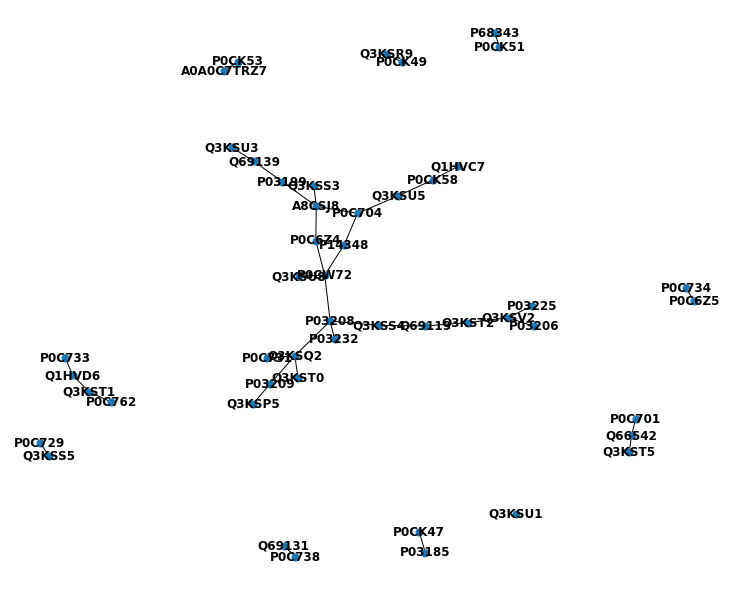

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

import networkx as nx
G = nx.Graph()

plt.figure(figsize=(10,8))

for data in EBV_EBV_mitab:
    p1 = data[0]
    p2 = data[1]
    G.add_edge(p1,p2)

nx.draw(G, with_labels=True, font_weight='bold', node_size=50)
#plt.show()
plt.savefig("EBV_EBV_network.jpeg")

In [30]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree

# Utility functions
# Extracting All go terms relative to provided UNIPROT accessor
def goTerms(xmlEntry):
    ns = '{http://uniprot.org/uniprot}'
    goTerms = xmlEntry.findall(ns +'dbReference[@type="GO"]')
    goTermList = []
    for goT in goTerms:
        gID   = goT.attrib['id']
        gName = goT.find(ns +'property[@type="term"]').attrib['value']
        goTermList.append({"name" : gName, "ID" : gID})
    return goTermList

# Return information about provided UNIPROT accessor as python dictionary
def proteinDict(uniprotID, root):
    ns   = '{http://uniprot.org/uniprot}'

    data = { "accession" : uniprotID,
             "geneName" : None,
             "name" : None,
             "GOterms" : None
           }

    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID: # entry is the node matching provided UNIPROT accessor
                e = entry.find(f"{ns}protein/{ns}recommendedName/{ns}fullName")
                if not e is None:
                    data["name"] = e.text
                e = "OUPSS##!!!"
                if not e is None:
                    data["geneName"] = e.text

                data["GOterms"] = goTerms(entry)
                return data
    raise ValueError(f"{uniprotID} nor found in XML document")

In [31]:
# Test
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()

In [32]:
EBV_node_label = {
    #dict uniprot: genename // uniprot
}

for d in EBV_EBV_mitab :
    for uniprotID in d[:2]:
        if not uniprotID in EBV_node_label :
            protData = proteinDict(uniprotID, root)
            EBV_node_label[uniprotID] = protData["geneName"] if protData["geneName"] else uniprotID

EBV_node_label

AttributeError: 'str' object has no attribute 'text'